In [12]:
import pandas as pd
import numpy as np
from datetime import date, time, datetime, timedelta
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Patch, Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import NullFormatter

## Constants

In [13]:
# Census population data from ACS 2019 for post-stratification
PATH_TO_CENSUS_DATA = '...'
# Safegraph social distancing metrics data 
PATH_TO_SAFEGRAPH_DATA = '...''
# We remove US holidays to study "regular" mobility patterns
holidays = [datetime(2019, 1, 1).date(), datetime(2020, 1, 1).date(),
            datetime(2019, 1, 21).date(), datetime(2020, 1, 20).date(),
            datetime(2019, 5, 27).date(), datetime(2020, 5, 25).date(),
            datetime(2019, 7, 4).date(), datetime(2020, 7, 3).date(),
            datetime(2019, 9, 2).date(), datetime(2020, 9, 7).date(),
            datetime(2019, 11, 11).date(), datetime(2020, 11, 11).date() ,
            datetime(2019, 11, 28).date(), datetime(2020, 11, 26).date(),
            datetime(2019, 11, 29).date(), datetime(2020, 11, 27).date(),
            datetime(2019, 12, 25).date(), datetime(2020, 12, 25).date()]

MANDATE = datetime(2020, 3, 23)

## Read data

In [3]:
population = pd.read_csv(
    PATH_TO_CENSUS_DATA,
    dtype = {'census_block_group':str})
# subset to Philadelphia
population = population.loc[population.census_block_group.apply(lambda x: x[:5]=='42101')]
# extract total population column and index by CBG
population = population.set_index('census_block_group').B01003e1
population.name = 'population'

In [ ]:
# Dates of analysis
start_date, end_date = datetime(2019, 1, 1), datetime(2020, 7, 30)
dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Output
results = []
for date in dates:
    print(date)
    file_path = f"{PATH_TO_SAFEGRAPH_DATA}{date.strftime('%Y/%m/%d')}/{date.strftime('%Y-%m-%d')}-social-distancing.csv.gz"
    df = pd.read_csv(file_path, usecols=['origin_census_block_group', 'device_count', 'completely_home_device_count'],
                     dtype={'origin_census_block_group': str}).set_index('origin_census_block_group')
    df['population'] = population
    df['pct_at_home'] = df.completely_home_device_count / df.device_count
    
    # Calculate summary statistics
    metrics = {
        'pct_home': np.average(df.pct_at_home, weights=df.population),
        'upper_95': df.pct_at_home.quantile(0.975),
        'lower_95': df.pct_at_home.quantile(0.025)
    }
    metrics['date'] = date.date()
    results.append(metrics)

# Convert list of dictionaries to DataFrame
home_stats = pd.DataFrame(results).set_index('date')

## Plotting

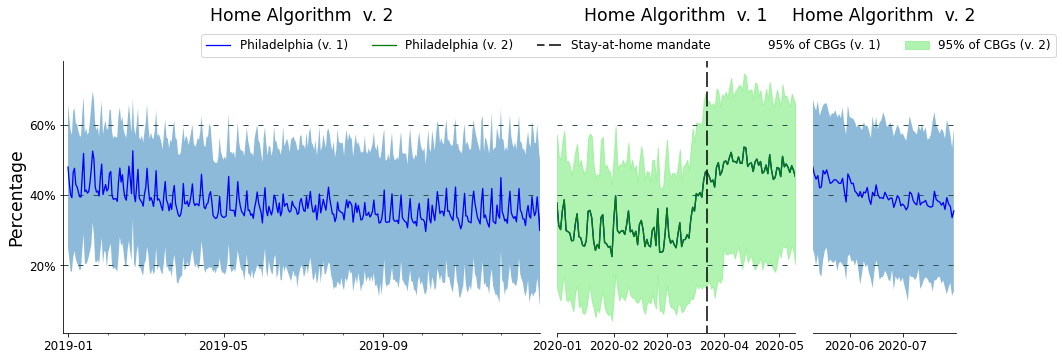

In [19]:
def smooth_series(series, window=7):
    """Applies a rolling average to a pandas Series with a default 7-day window."""
    return series.rolling(window, min_periods=1).mean()

# Define the boundaries for the subplots
cut_dates = [datetime(2020, 1, 1).date(), datetime(2020, 5, 10).date()]

# Create the plot with three subplots side by side, sharing the y-axis
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True, gridspec_kw={'width_ratios': [9, 4.5, 2.7], 'wspace': 0.06})

# Plot data for each subplot
for i, ax in enumerate(axes):    
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(fontsize='large')
    ax.set_yticks([0.2, 0.4, 0.6])
    #ax.set_ylim((0.07, 0.71))
    if i == 0:  # Leftmost plot
        ax.set_ylabel('Percentage', fontsize='xx-large')
        ax.xaxis.set_major_locator(MonthLocator(bymonth=(1, 5, 9)))
        ax.set_xlim((datetime(2018,12,28).date(), datetime(2019,12,31).date()))
        ax.set_title("Home Algorithm  v. 2", fontsize='xx-large', pad=40)
        ax.fill_between(home_stats.loc[:cut_dates[0]].index, home_stats['lower_95'][:cut_dates[0]], home_stats['upper_95'][:cut_dates[0]], alpha=0.5, label = '95% of CBGs')
        ax.plot(home_stats.loc[:cut_dates[0]].index, home_stats['pct_home'][:cut_dates[0]], linewidth=1.3, color='blue', label = 'Philadelphia')
        ax.tick_params(axis='both', labelsize='large')
    elif i == 1:  # Middle plot
        ax.xaxis.set_major_locator(MonthLocator())
        ax.set_xlim((datetime(2020,1,1).date(), datetime(2020,5,10).date()))
        ax.set_title("Home Algorithm  v. 1", fontsize='xx-large', pad=40)
        #fake to create the labels I need
        ax.fill_between(home_stats.loc[cut_dates[0]:cut_dates[1]].index, home_stats['lower_95'][cut_dates[0]:cut_dates[1]], home_stats['upper_95'][cut_dates[0]:cut_dates[1]],
                        alpha=0, label = '95% of CBGs (v. 1)')        
        ax.plot(home_stats.loc[cut_dates[0]:cut_dates[1]].index, home_stats['pct_home'][cut_dates[0]:cut_dates[1]], linewidth=1.3, color='blue', label = 'Philadelphia (v. 1)')
        
        ax.fill_between(home_stats.loc[cut_dates[0]:cut_dates[1]].index, home_stats['lower_95'][cut_dates[0]:cut_dates[1]], home_stats['upper_95'][cut_dates[0]:cut_dates[1]],
                        alpha=0.7, label = '95% of CBGs (v. 2)', color='lightgreen')
        ax.plot(home_stats.loc[cut_dates[0]:cut_dates[1]].index, home_stats['pct_home'][cut_dates[0]:cut_dates[1]], linewidth=1.3, color='green', label = 'Philadelphia (v. 2)')
        
        # Add stay-at-home mandate line
        ax.axvline(MANDATE, linewidth=1.5, color='k', linestyle=(5, (10, 3)), label= 'Stay-at-home mandate')
        ax.tick_params(axis='y', which='both', left=False)
        ax.tick_params(axis='x', labelsize='large')
        ax.legend(loc='upper center', bbox_to_anchor=(0.3, 1.12), ncol=5, fontsize='large')
        
    else:  # Rightmost plot
        ax.xaxis.set_major_locator(MonthLocator())
        ax.set_xlim((datetime(2020,5,11).date(), datetime(2020,7,31).date()))
        ax.set_title("Home Algorithm  v. 2", fontsize='xx-large', pad=40)
        ax.fill_between(home_stats.loc[cut_dates[1]:].index, home_stats['lower_95'][cut_dates[1]:], home_stats['upper_95'][cut_dates[1]:], alpha=0.5)
        ax.plot(home_stats.loc[cut_dates[1]:].index, home_stats['pct_home'][cut_dates[1]:], linewidth=1.3, color='blue')
        ax.tick_params(axis='y', which='both', left=False)
        ax.tick_params(axis='x', labelsize='large')
    
    # Customize axes
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(i == 0)  # Only show left spine for the leftmost plot
    ax.spines['right'].set_visible(False)  # No right spine
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    ax.grid(linestyle=(0, (5, 10)), linewidth=1, axis='y', color = 'darkslategray')
    
plt.show()